Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

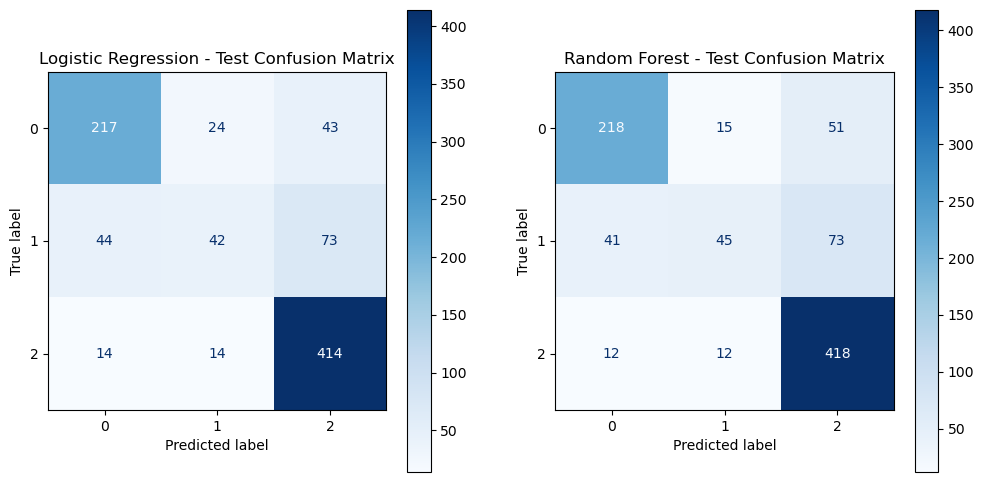

Cohen's Kappa (Test): 0.79
Pearson Correlation (Test): 0.87


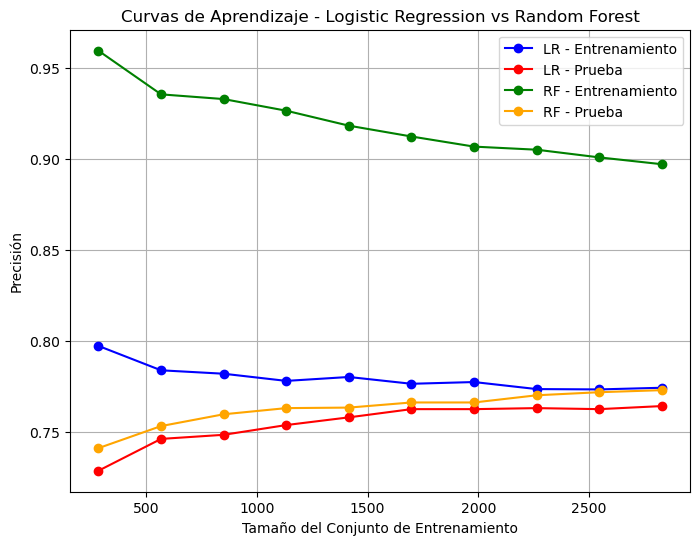

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Cargar los datos.
file_path = 'data.csv'  
data = pd.read_csv(file_path, delimiter=';')

# Ver las primeras filas del conjunto de datos.
print(data.columns)
print(data.info())
print(data.describe())

# Codificar la variable objetivo (Target).
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Target'] = encoder.fit_transform(data['Target'])  # ['Dropout', 'Enrolled', 'Graduate']

# Separar características (X) y objetivo (y).
X = data.drop(columns=['Target'])
y = data['Target']

# Dividir en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Escalar las características numéricas.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Optimización de Regresión Logística ---
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Búsqueda de hiperparámetros con GridSearchCV para Regresión Logística.
lr_params = {'C': np.logspace(-4, 4, 20), 'solver': ['liblinear']}
lr_cv = GridSearchCV(lr_clf, lr_params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
lr_cv.fit(X_train, y_train)

# Mostrar los mejores parámetros de Regresión Logística.
best_lr_params = lr_cv.best_params_
print(f'\nMejores parámetros para Regresión Logística: {best_lr_params}')

# Ajustar el modelo de Regresión Logística con los mejores parámetros.
lr_clf = LogisticRegression(**best_lr_params, max_iter=1000)
lr_clf.fit(X_train, y_train)

# --- Optimización de Random Forest ---
rf_clf = RandomForestClassifier(random_state=42)

# Búsqueda de hiperparámetros con GridSearchCV para Random Forest.
rf_params = {
    'n_estimators': [500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}
rf_cv = GridSearchCV(rf_clf, rf_params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_cv.fit(X_train, y_train)

# Mostrar los mejores parámetros de Random Forest.
best_rf_params = rf_cv.best_params_
print(f'\nMejores parámetros para Random Forest: {best_rf_params}')

# Ajustar el modelo de Random Forest con los mejores parámetros.
rf_clf = RandomForestClassifier(**best_rf_params, random_state=42)
rf_clf.fit(X_train, y_train)

# --- Comparación de los Modelos Optimizados ---

# Predicciones de ambos modelos.
lr_pred_train = lr_clf.predict(X_train)
lr_pred_test = lr_clf.predict(X_test)

rf_pred_train = rf_clf.predict(X_train)
rf_pred_test = rf_clf.predict(X_test)

# 1. Comparación básica de desempeño (Precisión).
lr_train_acc = accuracy_score(y_train, lr_pred_train) * 100
lr_test_acc = accuracy_score(y_test, lr_pred_test) * 100
rf_train_acc = accuracy_score(y_train, rf_pred_train) * 100
rf_test_acc = accuracy_score(y_test, rf_pred_test) * 100

print(f'Logistic Regression - Train Accuracy: {lr_train_acc:.2f}% | Test Accuracy: {lr_test_acc:.2f}%')
print(f'Random Forest - Train Accuracy: {rf_train_acc:.2f}% | Test Accuracy: {rf_test_acc:.2f}%')

# Reporte de clasificación.
print("Logistic Regression Classification Report (Test):")
print(classification_report(y_test, lr_pred_test))

print("Random Forest Classification Report (Test):")
print(classification_report(y_test, rf_pred_test))

# 2. Comparación de Matrices de Confusión.
lr_cm_test = confusion_matrix(y_test, lr_pred_test)
rf_cm_test = confusion_matrix(y_test, rf_pred_test)

# Visualización de matrices de confusión.
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(lr_cm_test, display_labels=lr_clf.classes_).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Logistic Regression - Test Confusion Matrix")
ConfusionMatrixDisplay(rf_cm_test, display_labels=rf_clf.classes_).plot(ax=axes[1], cmap='Blues')
axes[1].set_title("Random Forest - Test Confusion Matrix")
plt.show()

# 3. Análisis de Concordancia.
kappa_test = cohen_kappa_score(lr_pred_test, rf_pred_test)
print(f"Cohen's Kappa (Test): {kappa_test:.2f}")

# 4. Correlación de Pearson.
pearson_test, _ = pearsonr(lr_pred_test, rf_pred_test)
print(f"Pearson Correlation (Test): {pearson_test:.2f}")

# 5. Curvas de Aprendizaje.
from sklearn.model_selection import learning_curve

train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(lr_clf, X_train, y_train, cv=5, n_jobs=-1,
                                                                 train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(rf_clf, X_train, y_train, cv=5, n_jobs=-1,
                                                                 train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean_lr = train_scores_lr.mean(axis=1)
test_mean_lr = test_scores_lr.mean(axis=1)
train_mean_rf = train_scores_rf.mean(axis=1)
test_mean_rf = test_scores_rf.mean(axis=1)

# Graficar las curvas de aprendizaje.
plt.figure(figsize=(8, 6))
plt.plot(train_sizes_lr, train_mean_lr, label='LR - Entrenamiento', color='blue', marker='o')
plt.plot(train_sizes_lr, test_mean_lr, label='LR - Prueba', color='red', marker='o')
plt.plot(train_sizes_rf, train_mean_rf, label='RF - Entrenamiento', color='green', marker='o')
plt.plot(train_sizes_rf, test_mean_rf, label='RF - Prueba', color='orange', marker='o')
plt.title('Curvas de Aprendizaje - Logistic Regression vs Random Forest')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Precisión')
plt.legend(loc='best')
plt.grid(True)
plt.show()


Index(['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance\t', 'Previous qualification',
       'Previous qualification (grade)', 'Nacionality',
       'Mother's qualification', 'Father's qualification',
       'Mother's occupation', 'Father's occupation', 'Admission grade',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder',
       'Age at enrollment', 'International',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd

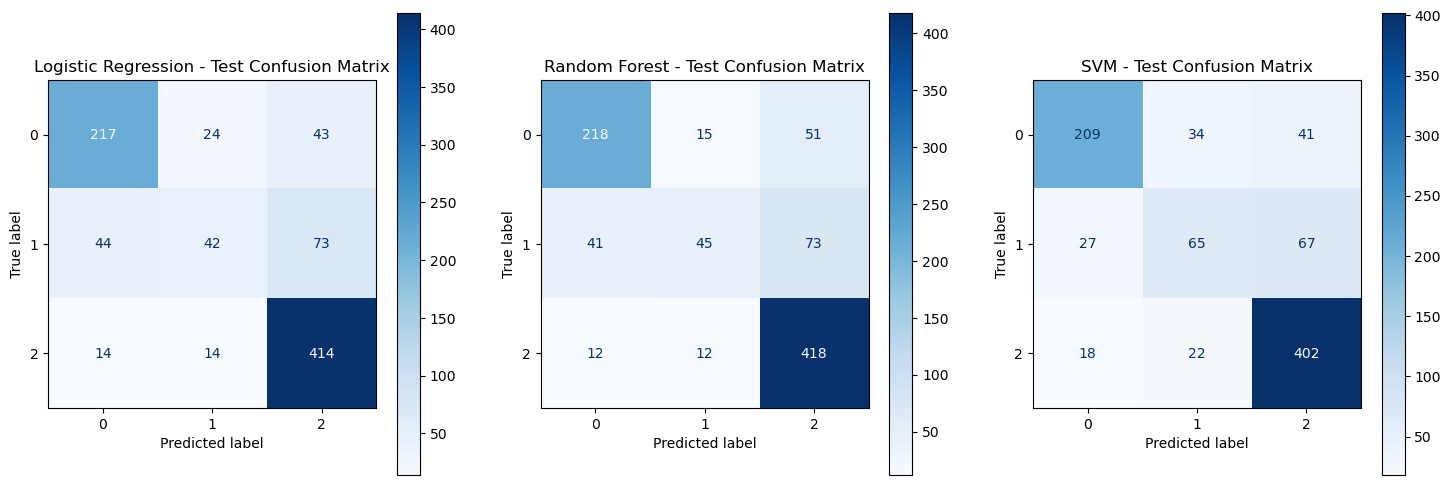

Cohen's Kappa (Logistic Regression vs Random Forest): 0.79
Cohen's Kappa (Logistic Regression vs SVM): 0.82
Cohen's Kappa (Random Forest vs SVM): 0.78
Pearson Correlation (Logistic Regression vs Random Forest): 0.87
Pearson Correlation (Logistic Regression vs SVM): 0.90
Pearson Correlation (Random Forest vs SVM): 0.87


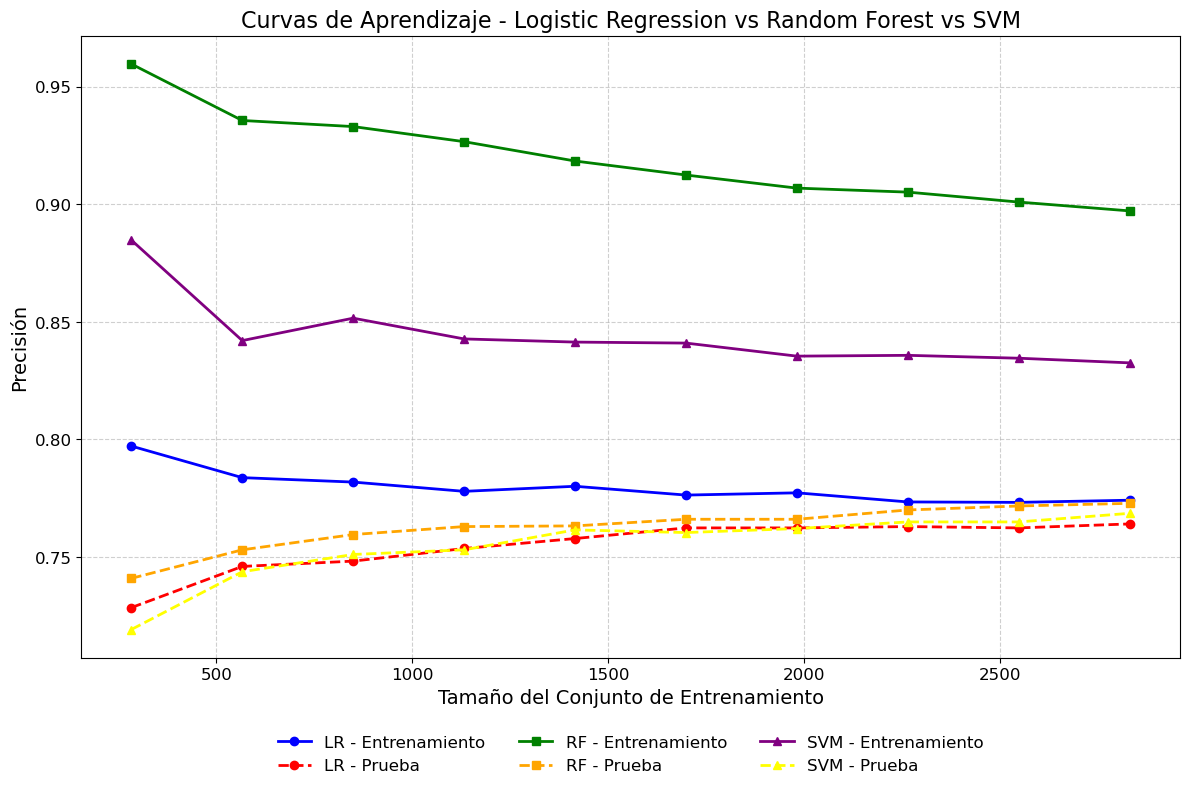

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Cargar los datos.
file_path = 'data.csv'  
data = pd.read_csv(file_path, delimiter=';')

# Ver las primeras filas del conjunto de datos.
print(data.columns)
print(data.info())
print(data.describe())

# Codificar la variable objetivo (Target).
encoder = LabelEncoder()
data['Target'] = encoder.fit_transform(data['Target'])  # ['Dropout', 'Enrolled', 'Graduate']

# Separar características (X) y objetivo (y).
X = data.drop(columns=['Target'])
y = data['Target']

# Dividir en conjuntos de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Escalar las características numéricas.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Optimización de Regresión Logística ---
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Búsqueda de hiperparámetros con GridSearchCV para Regresión Logística.
lr_params = {'C': np.logspace(-4, 4, 20), 'solver': ['liblinear']}
lr_cv = GridSearchCV(lr_clf, lr_params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
lr_cv.fit(X_train, y_train)

# Mostrar los mejores parámetros de Regresión Logística.
best_lr_params = lr_cv.best_params_
print(f'\nMejores parámetros para Regresión Logística: {best_lr_params}')

# Ajustar el modelo de Regresión Logística con los mejores parámetros.
lr_clf = LogisticRegression(**best_lr_params, max_iter=1000)
lr_clf.fit(X_train, y_train)

# --- Optimización de Random Forest ---
rf_clf = RandomForestClassifier(random_state=42)

# Búsqueda de hiperparámetros con GridSearchCV para Random Forest.
rf_params = {
    'n_estimators': [500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}
rf_cv = GridSearchCV(rf_clf, rf_params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_cv.fit(X_train, y_train)

# Mostrar los mejores parámetros de Random Forest
best_rf_params = rf_cv.best_params_
print(f'\nMejores parámetros para Random Forest: {best_rf_params}')

# Ajustar el modelo de Random Forest con los mejores parámetros.
rf_clf = RandomForestClassifier(**best_rf_params, random_state=42)
rf_clf.fit(X_train, y_train)

# --- Optimización de SVM ---
svm_clf = SVC()

# Búsqueda de hiperparámetros con GridSearchCV para SVM.
svm_params = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 20], 
    'gamma': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1],
    'kernel': ['linear', 'poly', 'rbf']
}
svm_cv = GridSearchCV(svm_clf, svm_params, n_jobs=-1, cv=5, verbose=1, scoring='accuracy')
svm_cv.fit(X_train, y_train)

# Mostrar los mejores parámetros de SVM.
best_svm_params = svm_cv.best_params_
print(f'\nMejores parámetros para SVM: {best_svm_params}')

# Ajustar el modelo de SVM con los mejores parámetros.
svm_clf = SVC(**best_svm_params)
svm_clf.fit(X_train, y_train)

# --- Comparación de los Modelos Optimizados ---

# Predicciones de los modelos optimizados
lr_pred_train = lr_clf.predict(X_train)
lr_pred_test = lr_clf.predict(X_test)

rf_pred_train = rf_clf.predict(X_train)
rf_pred_test = rf_clf.predict(X_test)

svm_pred_train = svm_clf.predict(X_train)
svm_pred_test = svm_clf.predict(X_test)

# 1. Comparación básica de desempeño (Precisión).
lr_train_acc = accuracy_score(y_train, lr_pred_train) * 100
lr_test_acc = accuracy_score(y_test, lr_pred_test) * 100
rf_train_acc = accuracy_score(y_train, rf_pred_train) * 100
rf_test_acc = accuracy_score(y_test, rf_pred_test) * 100
svm_train_acc = accuracy_score(y_train, svm_pred_train) * 100
svm_test_acc = accuracy_score(y_test, svm_pred_test) * 100

print(f'Logistic Regression - Train Accuracy: {lr_train_acc:.2f}% | Test Accuracy: {lr_test_acc:.2f}%')
print(f'Random Forest - Train Accuracy: {rf_train_acc:.2f}% | Test Accuracy: {rf_test_acc:.2f}%')
print(f'SVM - Train Accuracy: {svm_train_acc:.2f}% | Test Accuracy: {svm_test_acc:.2f}%')

# Reporte de clasificación.
print("Logistic Regression Classification Report (Test):")
print(classification_report(y_test, lr_pred_test))

print("Random Forest Classification Report (Test):")
print(classification_report(y_test, rf_pred_test))

print("SVM Classification Report (Test):")
print(classification_report(y_test, svm_pred_test))

# 2. Comparación de Matrices de Confusión.
lr_cm_test = confusion_matrix(y_test, lr_pred_test)
rf_cm_test = confusion_matrix(y_test, rf_pred_test)
svm_cm_test = confusion_matrix(y_test, svm_pred_test)

# Visualización de matrices de confusión.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
ConfusionMatrixDisplay(lr_cm_test, display_labels=lr_clf.classes_).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Logistic Regression - Test Confusion Matrix")
ConfusionMatrixDisplay(rf_cm_test, display_labels=rf_clf.classes_).plot(ax=axes[1], cmap='Blues')
axes[1].set_title("Random Forest - Test Confusion Matrix")
ConfusionMatrixDisplay(svm_cm_test, display_labels=svm_clf.classes_).plot(ax=axes[2], cmap='Blues')
axes[2].set_title("SVM - Test Confusion Matrix")
plt.show()

# 3. Análisis de Concordancia.
kappa_lr_rf = cohen_kappa_score(lr_pred_test, rf_pred_test)
kappa_lr_svm = cohen_kappa_score(lr_pred_test, svm_pred_test)
kappa_rf_svm = cohen_kappa_score(rf_pred_test, svm_pred_test)

print(f"Cohen's Kappa (Logistic Regression vs Random Forest): {kappa_lr_rf:.2f}")
print(f"Cohen's Kappa (Logistic Regression vs SVM): {kappa_lr_svm:.2f}")
print(f"Cohen's Kappa (Random Forest vs SVM): {kappa_rf_svm:.2f}")

# 4. Correlación de Pearson.
pearson_lr_rf, _ = pearsonr(lr_pred_test, rf_pred_test)
pearson_lr_svm, _ = pearsonr(lr_pred_test, svm_pred_test)
pearson_rf_svm, _ = pearsonr(rf_pred_test, svm_pred_test)

print(f"Pearson Correlation (Logistic Regression vs Random Forest): {pearson_lr_rf:.2f}")
print(f"Pearson Correlation (Logistic Regression vs SVM): {pearson_lr_svm:.2f}")
print(f"Pearson Correlation (Random Forest vs SVM): {pearson_rf_svm:.2f}")

# 5. Curvas de Aprendizaje.
train_sizes_lr, train_scores_lr, test_scores_lr = learning_curve(lr_clf, X_train, y_train, cv=5, n_jobs=-1,
                                                                 train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(rf_clf, X_train, y_train, cv=5, n_jobs=-1,
                                                                 train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')
train_sizes_svm, train_scores_svm, test_scores_svm = learning_curve(svm_clf, X_train, y_train, cv=5, n_jobs=-1,
                                                                     train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Promediar las puntuaciones de entrenamiento y prueba.
train_mean_lr = train_scores_lr.mean(axis=1)
test_mean_lr = test_scores_lr.mean(axis=1)
train_mean_rf = train_scores_rf.mean(axis=1)
test_mean_rf = test_scores_rf.mean(axis=1)
train_mean_svm = train_scores_svm.mean(axis=1)
test_mean_svm = test_scores_svm.mean(axis=1)

# Graficar las curvas de aprendizaje.
plt.figure(figsize=(12, 8)) 
plt.plot(train_sizes_lr, train_mean_lr, label='LR - Entrenamiento', color='blue', linestyle='-', linewidth=2, marker='o')
plt.plot(train_sizes_lr, test_mean_lr, label='LR - Prueba', color='red', linestyle='--', linewidth=2, marker='o')
plt.plot(train_sizes_rf, train_mean_rf, label='RF - Entrenamiento', color='green', linestyle='-', linewidth=2, marker='s')
plt.plot(train_sizes_rf, test_mean_rf, label='RF - Prueba', color='orange', linestyle='--', linewidth=2, marker='s')
plt.plot(train_sizes_svm, train_mean_svm, label='SVM - Entrenamiento', color='purple', linestyle='-', linewidth=2, marker='^')
plt.plot(train_sizes_svm, test_mean_svm, label='SVM - Prueba', color='yellow', linestyle='--', linewidth=2, marker='^')  

# Configuración gráfica.
plt.title('Curvas de Aprendizaje - Logistic Regression vs Random Forest vs SVM', fontsize=16)
plt.xlabel('Tamaño del Conjunto de Entrenamiento', fontsize=14)
plt.ylabel('Precisión', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12, frameon=False)  
plt.tight_layout()
plt.show()
